In [ ]:
import os
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 59.9696 - mae: 7.7341 - val_loss: 8.8655 - val_mae: 2.8125
Epoch 2/20
1/1 [==============================] - 1s 710ms/step - loss: 0.7652 - mae: 0.7974 - val_loss: 1.2388 - val_mae: 0.9636
Epoch 3/20
1/1 [==============================] - 1s 737ms/step - loss: 6.7355 - mae: 2.5695 - val_loss: 42.2792 - val_mae: 6.4301
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 20.0511 - mae: 4.4644 - val_loss: 2.2484 - val_mae: 1.2285
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 0.9501 - mae: 0.9073 - val_loss: 2.0737 - val_mae: 1.2277
Epoch 6/20
1/1 [==============================] - 1s 750ms/step - loss: 9.8857 - mae: 3.1234 - val_loss: 2.0924 - val_mae: 1.2346
Epoch 7/20
1/1 [==============================] - 1s 796ms/step - loss: 9.9700 - mae: 3.1369 - val_loss: 1.0476 - val_mae: 0.8007
Epoch 8/20
1/1 [==============================] - 1s 1s/step - loss: 3.2709 - mae: 1.7735 - val_

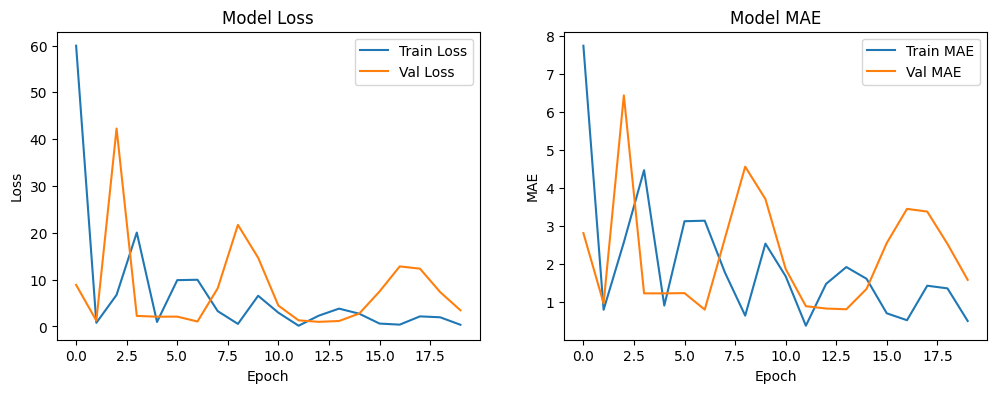

In [ ]:
# Function to create a dummy image
def create_dummy_image(file_path, num_people):
    width, height = 224, 224
    image = Image.new('RGB', (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(image)
    for i in range(num_people):
        x, y = np.random.randint(0, width), np.random.randint(0, height)
        draw.ellipse((x-10, y-10, x+10, y+10), fill=(255, 0, 0))
    image.save(file_path)

# Function to create dataset directories and files
def create_mock_dataset(base_dir='/content/drive/MyDrive/number of person/UCFCrowdCountingDataset_CVPR13/UCF_CC_50', num_samples=5):
    sets = ['train', 'val', 'test']
    for s in sets:
        set_dir = os.path.join(base_dir, s)
        images_dir = os.path.join(set_dir, 'images')
        annotations_file = os.path.join(set_dir, 'Readme.txt')

        # Create directories if they don't exist
        os.makedirs(images_dir, exist_ok=True)

        with open(annotations_file, 'w') as f:
            for i in range(num_samples):
                num_people = np.random.randint(1, 10)  # Random number of people between 1 and 9
                img_filename = f'image_{i+1}.jpg'
                img_path = os.path.join(images_dir, img_filename)
                create_dummy_image(img_path, num_people)
                f.write(f'{img_filename} {num_people}\n')

# Create the mock dataset
create_mock_dataset()

# Function to load the dataset
def load_dataset(data_dir):
    images = []
    counts = []
    annotations_path = os.path.join(data_dir, 'Readme.txt')

    # Check if the annotations file exists
    if not os.path.isfile(annotations_path):
        raise FileNotFoundError(f"Annotations file not found at {annotations_path}")

    with open(annotations_path, 'r') as f:
        for line in f:
            img_name, count = line.strip().split()
            img_path = os.path.join(data_dir, 'images', img_name)
            if not os.path.isfile(img_path):
                raise FileNotFoundError(f"Image file not found at {img_path}")
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            counts.append(int(count))

    images = np.array(images)
    counts = np.array(counts)
    return images, counts

# Load the datasets
train_images, train_counts = load_dataset('/content/drive/MyDrive/number of person/UCFCrowdCountingDataset_CVPR13/UCF_CC_50/train')
val_images, val_counts = load_dataset('/content/drive/MyDrive/number of person/UCFCrowdCountingDataset_CVPR13/UCF_CC_50/val')
test_images, test_counts = load_dataset('/content/drive/MyDrive/number of person/UCFCrowdCountingDataset_CVPR13/UCF_CC_50/test')

# Normalize pixel values
train_images, val_images, test_images = train_images / 255.0, val_images / 255.0, test_images / 255.0

# Build the model
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

model = build_model()

# Train the model
history = model.fit(train_images, train_counts, epochs=20, validation_data=(val_images, val_counts))

# Evaluate the model
test_loss, test_mae = model.evaluate(test_images, test_counts)
print(f'Test MAE: {test_mae}')

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.show()

# Predict the number of people in new images
def predict_people_count(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    return int(round(prediction[0][0]))

# Example usage:
# print(predict_people_count('dataset/test/images/image_1.jpg'))